# Data Visualization Capstone Project

## Project Introdution

This notebook develops the work associated with the above project. The requirement is to select a dataset or visualization from the [Makeover Monday](https://www.makeovermonday.co.uk/data/) site and improve it by creating a different dashboard/data presentation or animated story. 

It will be accompanied by a blog post that reflects on what improvements were made.

The required steps are:
- Step 1
    - Choose a dataset from the Makeover Monday site
    - Capture both the source article/visualization and the source data
- Step 2
    - Explore the data to identify any limitations and biases that can occur in collection, processing and insights
    - Document these in the blog
- Step 3
    - Dashboard: Define what questions the dashboard user will be able to answer and include in the blog
- Step 4
    - Complete the analysis and visualization
    - Include a link in your animated data story
- Step 5
    - Explain why your visualization is unique and improves on the original
    - Describe how annotations, chart choice, alignment, layouts make your data visualization better than the current version

## Dataset Introduction

The dataset that I will be using, inculding the visualization, can be found [here](https://www.nasa.gov/mission_pages/station/spacewalks/). 

The current visualization looks like this:

!['image'](nasa_spacewalks.PNG)

The data is found in text form on the site and will be gathered by scraping the page.

## Gather

In [362]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [12]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

For info on removing/hiding cells, check out this [resource](https://jupyter.org/jupyter-book/features/hiding.html).

In [6]:
r = requests.get('https://www.nasa.gov/mission_pages/station/spacewalks/')
soup = BeautifulSoup(r.text, 'lxml')
#for script in soup(['script', 'style']):
#    script.decompose()

print(soup.get_text())

































{
    "@context": "http://schema.org",
    "@graph": [
        {
            "@type": "Article",
            "headline": "Space Station Spacewalks",
            "name": "Space Station Spacewalks",
            "description": "There have been 217 spacewalks at the International Space Station.",
            "author": {
                "@type": "Person",
                "name": "Mark Garcia"
            },
            "publisher": {
                "@type": "Organization",
                "@id": "https://www.nasa.gov",
                "name": "NASA",
                "url": "https://www.nasa.gov",
                "sameAs": "https://twitter.com/nasa,https://www.facebook.com/nasa,https://instagram.com/nasa,https://plus.google.com/+NASA",
                "logo": {
                    "@type": "ImageObject",
                    "url": "https://www.nasa.gov/sites/all/themes/custom/nasatwo/images/nasa-logo.svg",
                    "width": "110",
                 

The original plan was to scrape the website for the data but it is written in such a way that this is not possible. 

Instead I:
1. Copied and pasted the page data in to word
2. Deleted all of the pictures and associated text
3. Extracted all of the hyperlinks ([Reference](https://answers.microsoft.com/en-us/msoffice/forum/all/how-do-i-extract-all-hyperlinks-from-word-document/cb1a57aa-a79f-40a3-a42c-5217433ce746)) and made sure the were in the correct order ([Reference](https://wordribbon.tips.net/T004803_Reversing_All_the_Paragraphs_in_a_Document.html))
4. Then collected the hyperlinks and text information into two csv's.

In [96]:
walks = pd.read_csv('data/spacewalks.csv', header=None)
walks.head()

,0,1,2
0,2019.0,Mission: Expedition 59,NaN
1,2019.0,"Date: April 8, 2019",NaN
2,2019.0,"Duration: 6 hours, 29 minutes",NaN
3,2019.0,"Spacewalkers: Anne McClain, David Saint-Jacques",NaN
4,2019.0,Mission: Expedition 59,NaN


In [8]:
links = pd.read_csv('hyperlinks.csv', header=None)
links.head()

,0
0,http://www.nasa.gov/mission_pages/station/expe...
1,https://go.nasa.gov/2Df8Zbh
2,https://www.nasa.gov/astronauts/biographies/an...
3,http://www.asc-csa.gc.ca/eng/astronauts/canadi...
4,http://www.nasa.gov/mission_pages/station/expe...


## Assess 1

### walks

The columns don't have headers which makes it harder to work with them. Let's change that and then go back to assessing.

In [97]:
walks.columns = ['year', 'info', 'missing']
assert walks.columns.to_list() == ['year', 'info', 'missing']

In [11]:
walks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871 entries, 0 to 870
Data columns (total 3 columns):
year       865 non-null float64
info       865 non-null object
missing    0 non-null float64
dtypes: float64(2), object(1)
memory usage: 20.5+ KB


**Findings**

- There is no data in the `missing` column so it can be deleted.
- There are some rows that seem to have no data in them.
- The data is currently not in a tidy format, with all data contained in `info`
- Year is `float` when it should be `int` (decided against `str` because want ordering qualities and don't need to be date)

It is preferrable to make this initial conversions and then continue with additional assessment.

## Wrangle 1
Before wrangling, let's make a copy.

In [115]:
walks_clean = walks.copy()

### Delete `missing` column

In [116]:
walks_clean.drop('missing', axis=1, inplace=True)
assert walks_clean.shape[1] == 2
assert 'missing' not in walks_clean.columns

### Delete rows with all `nan`

In [117]:
walks_clean.dropna(how='all', inplace=True)
assert walks_clean.isna().sum().sum() == 0

### Convert `year` to `int`

In [118]:
walks_clean['year'] = walks_clean['year'].astype(int)
assert walks_clean['year'].dtypes == int

### Convert to tidy format

- Split the columns on `:`
- Check split for unexpected values
- Drop `info` column
- Create columns for `Mission`, `Date`, `Duration`, `Spacewalkers`

In [119]:
walks_clean[['attribute', 'value']] = walks_clean['info'].str.split(':', expand=True)
walks_clean.head()

,year,info,attribute,value
0,2019,Mission: Expedition 59,Mission,Expedition 59
1,2019,"Date: April 8, 2019",Date,"April 8, 2019"
2,2019,"Duration: 6 hours, 29 minutes",Duration,"6 hours, 29 minutes"
3,2019,"Spacewalkers: Anne McClain, David Saint-Jacques",Spacewalkers,"Anne McClain, David Saint-Jacques"
4,2019,Mission: Expedition 59,Mission,Expedition 59


In [103]:
# What is the exact value of the first row in `value`?
walks_clean.loc[0, 'value']

'\xa0Expedition 59'

In [104]:
# What is the exact value of the first row in `attribute`?
walks_clean.loc[0, 'attribute']

'Mission'

In [120]:
# Replace the extra characters in `value`
walks_clean['value'] = walks_clean['value'].str.replace('\xa0', '', regex=False)
assert walks_clean['value'].str.contains('\xa0', regex=False).sum() == 0

In [121]:
# Drop info
walks_clean.drop('info', axis=1, inplace=True)
assert 'info' not in walks_clean.columns

Hmmm, it seems I missed a mission that had no space walks. Let's find it and manage it.

In [106]:
walks_clean[walks_clean['attribute'].str.contains('No spacewalks were conducted during this mission', regex=False)]

,year,attribute,value
217,2012,No spacewalks were conducted during this mission,None


In [107]:
walks_clean.iloc[210:221]

,year,attribute,value
210,2012,Duration,"8 hours, 17 minutes"
211,2012,Spacewalkers,"Sunita Williams, Aki Hoshide"
212,2012,Mission,Expedition 32
213,2012,Date,"Aug. 20, 2012"
214,2012,Duration,"5 hours, 51 minutes"
215,2012,Spacewalkers,"Gennady Padalka, Yuri Malenchenko"
216,2012,Mission,Expedition 31
217,2012,No spacewalks were conducted during this mission,None
218,2012,Mission,Expedition 30
219,2012,Date,"Feb. 16, 2012"


The two rows that need to be dropped are `216` and `217`

In [122]:
walks_clean.drop([216, 217], inplace=True)
assert walks_clean['attribute'].str.contains('No spacewalks were conducted during this mission', regex=False).sum() == 0

It also looks like I missed a mission name when gathering the data. Let's check that out.

In [109]:
walks_clean.loc[258:265]

,year,attribute,value
258,2011,Mission,Expedition 26
259,2011,Date,"Jan. 21, 2011"
260,2011,Duration,"5 hours, 23 minutes"
261,2011,Spacewalkers,"Dmitry Kondratyev, Oleg Skripochka"
262,2010,Date,"Nov. 15, 2010"
263,2010,Duration,"6 hours, 27 minutes"
264,2010,Spacewalkers,"Fyodor Yurchikhin, Oleg Skripochka"
265,2010,Mission,Expedition 24


Yes, there is no name for the missing after row 261. Let's fix that.

In [123]:
walks_clean.loc[:261].tail()

,year,attribute,value
257,2011,Spacewalkers,"Dmitry Kondratyev,Oleg Skripochka"
258,2011,Mission,Expedition 26
259,2011,Date,"Jan. 21, 2011"
260,2011,Duration,"5 hours, 23 minutes"
261,2011,Spacewalkers,"Dmitry Kondratyev,Oleg Skripochka"


In [124]:
walks_clean.loc[262:].head()

,year,attribute,value
262,2010,Date,"Nov. 15, 2010"
263,2010,Duration,"6 hours, 27 minutes"
264,2010,Spacewalkers,"Fyodor Yurchikhin,Oleg Skripochka"
265,2010,Mission,Expedition 24
266,2010,Date,"Aug. 16, 2010"


In [110]:
walks_clean.shape

(863, 3)

In [132]:
walks_clean = pd.concat([walks_clean.loc[:261], 
                         pd.DataFrame({'year': 2010, 'attribute': 'Mission', 'value':'Expedition 25'}, index=[0]), 
                         walks_clean.loc[262:]])
assert walks_clean.shape[0] == 864

In [133]:
walks_clean.reset_index(inplace=True)
walks_clean.drop('index', axis=1, inplace=True)
assert walks_clean.shape[1] == 3

Now to work out how to rearrange the columns. 

In [137]:
test = walks_clean.loc[0:3, ['attribute', 'value']].transpose()
test

,0,1,2,3
attribute,Mission,Date,Duration,Spacewalkers
value,Expedition 59,"April 8, 2019","6 hours, 29 minutes","Anne McClain,David Saint-Jacques"


In [138]:
test_cols = ['mission_name', 'date', 'walk_duration', 'spacewalkers']
test.columns = test_cols
test['year'] = walks_clean.loc[0, 'year']
df_cols = ['year', 'mission_name', 'date', 'walk_duration', 'spacewalkers']
test = test[df_cols]
test_df = pd.DataFrame(test.loc['value']).transpose()
test_df

,year,mission_name,date,walk_duration,spacewalkers
value,2019,Expedition 59,"April 8, 2019","6 hours, 29 minutes","Anne McClain,David Saint-Jacques"


From here, `test.loc['value']` can be appended to a dataframe.

In [78]:
df = pd.DataFrame([], columns=df_cols)
df

,year,mission_name,date,walk_duration,spacewalkers


In [79]:
pd.concat([df, test_df])

,year,mission_name,date,walk_duration,spacewalkers
value,2019,Expedition 59,"April 8, 2019","6 hours, 29 minutes","Anne McClain,David Saint-Jacques"


In [173]:
row_range = np.arange(0, walks_clean.shape[0], 4)
temp_cols = ['mission_name', 'date', 'walk_duration', 'spacewalkers']
df_cols = ['year', 'mission_name', 'date', 'walk_duration', 'spacewalkers']

df = pd.DataFrame([], columns=df_cols)

for i in row_range:
    temp_df = walks_clean.loc[i:i+3, ['attribute', 'value']].transpose()
    temp_df.columns = temp_cols
    temp_df['year'] = walks_clean.loc[i, 'year']
    temp_df = temp_df[df_cols]
    df = pd.concat([df, pd.DataFrame(temp_df.loc['value']).transpose()])
    if df.iloc[-1, 1][0] != 'E' and df.iloc[-1, 1][0] != 'S':
        print(df.iloc[-1])
        break

In [139]:
df.shape

(216, 5)

The total number of space walks (according to the original visual) is 216. This matches the number of rows in our df and so can be assumed to be correct.

## Assess 2
### df

In [143]:
df.head()

,year,mission_name,date,walk_duration,spacewalkers
value,2019,Expedition 59,"April 8, 2019","6 hours, 29 minutes","Anne McClain,David Saint-Jacques"
value,2019,Expedition 59,"March 29, 2019","6 hours, 45 minutes","Nick Hague,Christina Koch"
value,2019,Expedition 59,"March 22, 2019","6 hours, 39 minutes","Anne McClain,Nick Hague"
value,2018,Expedition 57,"Dec. 11, 2018","7 hours, 45 minutes","Oleg Kononenko,Sergey Prokopyev"
value,2018,Expedition 56,"Aug. 15, 2018","7 hours, 46 minutes","Oleg Artemyev,Sergey Prokopyev"


In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 216 entries, value to value
Data columns (total 5 columns):
year             216 non-null object
mission_name     216 non-null object
date             216 non-null object
walk_duration    216 non-null object
spacewalkers     216 non-null object
dtypes: object(5)
memory usage: 15.1+ KB


**Findings**

- All index values are `value`, it would be good if these were unique for referencing
- All of the columns are now objects, it would be better if they had correct dtypes, e.g. for `date` and `walk_duration`
- The `year` column can now be dropped as this is captured in the date column
- It would be preferrable to split the astronaut names

### links

Which links contain astronaut names?

In [147]:
print(links.loc[3][0])

http://www.asc-csa.gc.ca/eng/astronauts/canadian/active/bio-david-saint-jacques.asp


In [148]:
links[links[0].str.contains('astronaut', regex=False)]

,0
2,https://www.nasa.gov/astronauts/biographies/an...
3,http://www.asc-csa.gc.ca/eng/astronauts/canadi...
6,https://www.nasa.gov/astronauts/biographies/ty...
7,https://www.nasa.gov/astronauts/biographies/ch...
10,https://www.nasa.gov/astronauts/biographies/an...
11,https://www.nasa.gov/astronauts/biographies/ty...
22,http://www.nasa.gov/astronauts/biographies/and...
23,http://www.nasa.gov/astronauts/biographies/ric...
26,http://www.nasa.gov/astronauts/biographies/ric...
29,http://www.nasa.gov/astronauts/biographies/and...


In [149]:
print(links.loc[577][0])

http://www.esa.int/esaHS/ESAOUUZUMOC_astronauts_0.html


It appears that links for Canadian, US and some European astronauts have the word "astronaut" in their address. But, the number of astronaut links should be twice the number of space walks, which would be 432, so we are definitely missing some links.

In addition, one of the identified links looks like a blog post. 

In [152]:
links[links[0].str.contains('bio', regex=False)]

,0
2,https://www.nasa.gov/astronauts/biographies/an...
3,http://www.asc-csa.gc.ca/eng/astronauts/canadi...
6,https://www.nasa.gov/astronauts/biographies/ty...
7,https://www.nasa.gov/astronauts/biographies/ch...
10,https://www.nasa.gov/astronauts/biographies/an...
11,https://www.nasa.gov/astronauts/biographies/ty...
22,http://www.nasa.gov/astronauts/biographies/and...
23,http://www.nasa.gov/astronauts/biographies/ric...
26,http://www.nasa.gov/astronauts/biographies/ric...
29,http://www.nasa.gov/astronauts/biographies/and...


Now we have 403 records, which is much closer. It looks like some of the recent Russian links don't use this term.

However, it may just be easier to manually record which space flight belongs to whom.

In [291]:
# 1 == US, 0 == RUS
walk_type = pd.DataFrame([
              ['Oleg Kononenko, Alexey Ovchinin', 0],
              ['Anne McClain, David Saint-Jacques', 1],
              ['Nick Hague, Christina Koch', 1],
              ['Anne McClain, Nick Hague', 1],
              ['Oleg Kononenko, Sergey Prokopyev', 0],
              ['Oleg Artemyev, Sergey Prokopyev', 0],
              ['Drew Feustel, Ricky Arnold', 1],
              ['Drew Feustel, Ricky Arnold', 1],
              ['Drew Feustel, Ricky Arnold', 1],
              ['Mark Vande Hei, Norishige Kanai', 1],
              ['Alexander Misurkin, Anton Shkaplerov', 0],
              ['Mark Vande Hei, Scott Tingle', 1],
              ['Randy Bresnik, Joe Acaba', 1],
              ['Randy Bresnik, Mark Vande Hei', 1],
              ['Randy Bresnik, Mark Vande Hei', 1],
              ['Fyodor Yurchikhin, Sergey Ryazanskiy', 0],
              ['Peggy Whitson, Jack Fischer', 1],
              ['Peggy Whitson, Jack Fischer', 1],
              ['Shane Kimbrough, Peggy Whitson', 1],
              ['Shane Kimbrough, Thomas Pesquet', 1],
              ['Shane Kimbrough, Thomas Pesquet', 1],
              ['Shane Kimbrough, Peggy Whitson', 1],
              ['Jeff Williams, Kate Rubins', 1], 
              ['Jeff Williams, Kate Rubins', 1],
              ['Yuri Malenchenko, Sergey Volkov', 0],
              ['Tim Kopra, Tim Peake', 1],
              ['Scott Kelly, Tim Kopra', 1],
              ['Scott Kelly, Kjell Lindgren', 1],
              ['Scott Kelly, Kjell Lindgren', 1],
              ['Gennady Padalka, Mikhail Kornienko', 0],
              ['Barry Wilmore, Terry Virts', 1],
              ['Barry Wilmore, Terry Virts', 1],
              ['Barry Wilmore, Terry Virts', 1],
              ['Max Suraev, Alexander Samokutyaev', 0],
              ['Reid Wiseman, Barry Wilmore', 1],
              ['Reid Wiseman, Alexander Gerst', 1],
              ['Alexander Skvortsov, Oleg Artemyev', 0], 
              ['Alexander Skvortsov, Oleg Artemyev', 0],
              ['Richard Mastracchio, Steve Swanson', 1],
              ['Oleg Kotov, Sergei Ryazanskiy', 0],
              ['Oleg Kotov, Sergei Ryazanskiy', 0],
              ['Richard Mastracchio, Mike Hopkins', 1],
              ['Richard Mastracchio, Mike Hopkins', 1],
              ['Oleg Kotov, Sergei Ryazanskiy', 0],
              ['Fyodor Yurchikhin, Alexander Misurkin', 0],
              ['Fyodor Yurchikhin, Alexander Misurkin', 0],
              ['Chris Cassidy, Luca Parmitano', 1],
              ['Chris Cassidy, Luca Parmitano', 1],
              ['Fyodor Yurchikhin, Alexander Misurkin', 0],
              ['Chris Cassidy, Thomas Marshburn', 1],
              ['Pavel Vinogradov, Roman Romanenko', 0],
              ['Sunita Williams, Aki Hoshide', 1],
              ['Sunita Williams, Aki Hoshide', 1],
              ['Sunita Williams, Aki Hoshide', 1],
              ['Gennady Padalka, Yuri Malenchenko', 0],
              ['Oleg Kononenko, Anton Shkaplerov', 0],
              ['Sergei Volkov, Alexander Samokutyaev', 0],
              ['Ron Garan, Mike Fossum', 1],
              ['Andrew Feustel, Greg Chamitoff', 1],
              ['Andrew Feustel, Mike Fincke', 1],
              ['Andrew Feustel, Mike Fincke', 1],
              ['Andrew Feustel, Greg Chamitoff', 1],
              ['Stephen Bowen, Alvin Drew', 1],
              ['Stephen Bowen, Alvin Drew', 1],
              ['Dmitry Kondratyev, Oleg Skripochka', 0],
              ['Dmitry Kondratyev, Oleg Skripochka', 0],
              ['Fyodor Yurchikhin, Oleg Skripochka', 0],
              ['Doug Wheelock, Tracy Caldwell-Dyson', 1],
              ['Doug Wheelock, Tracy Caldwell-Dyson', 1],
              ['Doug Wheelock, Tracy Caldwell-Dyson', 1],
              ['Fyodor Yurchikhin, Mikhail Kornienko', 0],
              ['Michael Good, Stephen Bowen', 1],
              ['Stephen Bowen, Michael Good', 1],
              ['Garret Reisman, Stephen Bowen', 1],
              ['Richard Mastracchio, Clayton Anderson', 1],
              ['Richard Mastracchio, Clayton Anderson', 1],
              ['Richard Mastracchio, Clayton Anderson', 1],
              ['Robert Behnken, Nicholas Patrick', 1],
              ['Robert Behnken, Nicholas Patrick', 1],
              ['Robert Behnken, Nicholas Patrick', 1],
              ['Oleg Kotov, Max Suraev', 0],
              ['Robert Satcher, Randolph Bresnik', 1],
              ['Michael Foreman, Randolph Bresnik', 1],
              ['Michael Foreman, Robert Satcher', 1],
              ['John Olivas, Christer Fuglesang', 1],
              ['John Olivas, Christer Fuglesang', 1],
              ['John Olivas, Nicole Stott', 1],
              ['Chris Cassidy, Thomas Marshburn', 1],
              ['Chris Cassidy, Thomas Marshburn', 1],
              ['David Wolf, Chris Cassidy', 1],
              ['David Wolf, Thomas Marshburn', 1],
              ['David Wolf, Tim Kopra', 1],
              ['Gennady Padalka, Michael Barratt', 0],
              ['Gennady Padalka, Michael Barratt', 0],
              ['Joseph Acaba, Richard Arnold', 1],
              ['Steve Swanson, Joseph Acaba', 1],
              ['Steve Swanson, Richard Arnold', 1],
              ['Yury Lonchakov, Mike Fincke', 0],
              ['Yury Lonchakov, Mike Fincke', 0],
              ['Stephen Bowen, Robert Kimbrough', 1],
              ['Heidemarie Stefanyshyn-Piper, Stephen Bowen', 1],
              ['Heidemarie Stefanyshyn-Piper, Robert Kimbrough', 1],
              ['Heidemarie Stefanyshyn-Piper, Stephen Bowen', 1],
              ['Sergei Volkov, Oleg Kononenko', 0],
              ['Sergei Volkov, Oleg Kononenko', 0],
              ['Mike Fossum, Ron Garan', 1],
              ['Mike Fossum, Ron Garan', 1],
              ['Mike Fossum, Ron Garan', 1],
              ['Michael Foreman, Robert Behnken', 1],
              ['Michael Foreman, Robert Behnken', 1],
              ['Richard Linnehan, Robert Behnken', 1], 
              ['Richard Linnehan, Michael Foreman', 1],
              ['Richard Linnehan, Garret Reisman', 1],
              ['Rex Walheim, Stanley Love', 1],
              ['Rex Walheim, Hans Schlegel', 1],
              ['Rex Walheim, Stanley Love', 1],
              ['Peggy Whitson, Dan Tani', 1],
              ['Peggy Whitson, Dan Tani', 1],
              ['Peggy Whitson, Dan Tani', 1],
              ['Peggy Whitson, Dan Tani', 1],
              ['Peggy Whitson, Yuri Malenchenko', 1],
              ['Scott Parazynski, Doug Wheelock', 1],
              ['Scott Parazynski, Dan Tani', 1],
              ['Scott Parazynski, Salizhan Sharipov', 1],
              ['Scott Parazynski, Doug Wheelock', 1],
              ['David Williams, Clayton Anderson', 1],
              ['Richard Mastracchio, Clayton Anderson', 1],
              ['Richard Mastracchio, David Williams', 1],
              ['Richard Mastracchio, David Williams', 1],
              ['Clayton Anderson, Fyodor Yurchikhin', 0],
              ['Fyodor Yurchikhin, Oleg Kotov', 0],
              ['Fyodor Yurchikhin, Oleg Kotov', 0],
              ['Patrick Forrester, Steve Swanson', 1],
              ['James Reilly, John Olivas', 1],
              ['Patrick Forrester, Steve Swanson', 1],
              ['James Reilly, John Olivas', 1],
              ['Mikhail Tyurin, Michael Lopez-Alegria', 0],
              ['Michael Lopez-Alegria, Sunita Williams', 1],
              ['Michael Lopez-Alegria, Sunita Williams', 1],
              ['Michael Lopez-Alegria, Sunita Williams', 1],
              ['Mikhail Tyurin, Michael Lopez-Alegria', 0],
              ['Bob Curbeam, Christer Fuglesang', 1],
              ['Bob Curbeam, Sunita Williams', 1],
              ['Bob Curbeam, Christer Fuglesang', 1],
              ['Bob Curbeam, Christer Fuglesang', 1],
              ['Joe Tanner, Heidemarie Stefanyshyn-Piper', 1],
              ['Dan Burbank, Steve MacLean', 1],
              ['Joe Tanner, Heidemarie Stefanyshyn-Piper', 1],
              ['Jeff Williams, Thomas Reiter', 1],
              ['Pavel Vinogradov, Jeff Williams', 0],
              ['Piers Sellers, Mike Fossum', 1],
              ['Piers Sellers, Mike Fossum', 1],
              ['Piers Sellers, Mike Fossum', 1],
              ['Bill McArthur, Valery Tokarev', 1],
              ['Bill McArthur, Valery Tokarev', 0],
              ['Sergei Krikalev, John Phillips', 0],
              ['Soichi Noguchi, Stephen Robinson', 1],
              ['Soichi Noguchi, Stephen Robinson', 1],
              ['Soichi Noguchi, Stephen Robinson', 1],
              ['Leroy Chiao, Salizhan Sharipov', 0],
              ['Leroy Chiao, Salizhan Sharipov', 0],
              ['Gennady Padalka, Mike Fincke', 1],
              ['Gennady Padalka, Mike Fincke', 1],
              ['Gennady Padalka, Mike Fincke', 1],
              ['Gennady Padalka, Mike Fincke', 1],
              ['Michael Foale, Alexander Kaleri', 0],
              ['Ken Bowersox, Don Pettit', 1],
              ['Ken Bowersox, Don Pettit', 1],
              ['Michael Lopez-Alegria, John Herrington', 1],
              ['Michael Lopez-Alegria, John Herrington', 1],
              ['Michael Lopez-Alegria, John Herrington', 1],
              ['David Wolf, Piers Sellers', 1],
              ['David Wolf, Piers Sellers', 1],
              ['David Wolf, Piers Sellers', 1],
              ['Valery Korzun, Sergei Treschev', 0],
              ['Valery Korzun, Peggy Whitson', 0],
              ['Franklin Chang-Diaz, Philippe Perrin', 1],
              ['Franklin Chang-Diaz, Philippe Perrin', 1],
              ['Franklin Chang-Diaz, Philippe Perrin', 1],
              ['Jerry Ross, Lee Morin', 1],
              ['Steven Smith, Rex Walheim', 1],
              ['Jerry Ross, Lee Morin', 1],
              ['Steven Smith, Rex Walheim', 1], 
              ['Carl Walz, Dan Bursch', 1],
              ['Yury Onufrienko, Dan Bursch', 0],
              ['Yury Onufrienko, Carl Walz', 1],
              ['Linda Godwin, Dan Tani', 1],
              ['Vladimir Dezhurov, Mikhail Tyurin', 0],
              ['Vladimir Dezhurov, Frank Culbertson', 0],
              ['Vladimir Dezhurov, Mikhail Tyurin', 0],
              ['Vladimir Dezhurov, Mikhail Tyurin', 0],
              ['Daniel Barry, Patrick Forrester', 1],
              ['Daniel Barry, Patrick Forrester', 1],
              ['Michael Gernhardt, James Reilly', 1],
              ['Michael Gernhardt, James Reilly', 1],
              ['Michael Gernhardt, James Reilly', 1],
              ['Yury Usachev, James Voss', 0],
              ['Chris Hadfield, Scott Parazynski', 1],
              ['Chris Hadfield, Scott Parazynski', 1],
              ['Andrew Thomas, Paul Richards', 1],
              ['James Voss, Susan Helms', 1],
              ['Thomas Jones, Robert Curbeam', 1],
              ['Thomas Jones, Robert Curbeam', 1],
              ['Thomas Jones, Robert Curbeam', 1],
              ['Joseph Tanner, Carlos Noriega', 1],
              ['Joseph Tanner, Carlos Noriega', 1],
              ['Joseph Tanner, Carlos Noriega', 1],
              ['Michael Lopez-Alegria, Peter J.Wisoff', 1],
              ['Leroy Chiao, Bill McArthur', 1],
              ['Michael Lopez-Alegria, Peter J.Wisoff', 1],
              ['Leroy Chiao, Bill McArthur', 1],
              ['Edward Lu, Yuri Malenchenko', 1],
              ['James Voss, Jeff Williams', 1],
              ['Tamara Jernigan, Daniel Barry', 1],
              ['Jerry Ross, James Newman', 1],
              ['Jerry Ross, James Newman', 1],
              ['Jerry Ross, James Newman', 1]])

In [158]:
walk_type.head()

,0,1
0,"Oleg Kononenko, Alexey Ovchinin",0
1,"Anne McClain, David Saint-Jacques",1
2,"Nick Hague, Christina Koch",1
3,"Anne McClain, Nick Hague",1
4,"Oleg Kononenko, Sergey Prokopyev",0


In [294]:
walk_type.columns = ['spacewalkers', 'us_rus']

In [292]:
walk_type.shape

(217, 2)

In [295]:
walk_type['us_rus'].sum()

167

I have credited four walks to the US more than I should have. However, it's very difficult to determine the source of the difference. If it's joined, it will be much easier to determine.

The `walk_type` can be joined on the main df.

## Wrange 2

All index values are value, it would be good if these were unique for referencing
All of the columns are now objects, it would be better if they had correct dtypes, e.g. for date and walk_duration
The year column can now be dropped as this is captured in the date column
It would be preferrable to split the astronaut names

In [269]:
df_clean = df.copy()

### Correct index values for `df`

In [270]:
df_clean.reset_index(inplace=True)
df_clean.drop('index', axis=1, inplace=True)
assert df_clean.shape[1] == 5

### Correct date dtype

In [168]:
df_clean.head()

,year,mission_name,date,walk_duration,spacewalkers
0,2019,Expedition 59,"April 8, 2019","6 hours, 29 minutes","Anne McClain,David Saint-Jacques"
1,2019,Expedition 59,"March 29, 2019","6 hours, 45 minutes","Nick Hague,Christina Koch"
2,2019,Expedition 59,"March 22, 2019","6 hours, 39 minutes","Anne McClain,Nick Hague"
3,2018,Expedition 57,"Dec. 11, 2018","7 hours, 45 minutes","Oleg Kononenko,Sergey Prokopyev"
4,2018,Expedition 56,"Aug. 15, 2018","7 hours, 46 minutes","Oleg Artemyev,Sergey Prokopyev"


Date time formatting is inconsistent - the first three are different for the next dates. What about the tail?

In [169]:
df_clean.tail()

,year,mission_name,date,walk_duration,spacewalkers
211,2000,STS-101,"May 22, 2000","6 hours, 44 minutes","James Voss,Jeff Williams"
212,1999,STS-96,"May 30, 1999","7 hours, 55 minutes","Tamara Jernigan,Daniel Barry"
213,1998,STS-88,"Dec. 12, 1998","6 hours, 59 minutes","Jerry Ross,James Newman"
214,1998,STS-88,"Dec. 9, 1998","7 hours, 2 minutes","Jerry Ross,James Newman"
215,1998,STS-88,"Dec. 7, 1998","7 hours, 21 minutes","Jerry Ross,James Newman"


There's some differences in the dates. Let's remove the `.` and then determine which are abbreviations or not using `.str.contains()`.

In [271]:
df_clean['date'] = df_clean['date'].str.replace('.', '', regex=False)

In [201]:
# Get non-abbr months
month_str = r'January|February|March|April|May|June|July|August|September|October|November|December'
date_not_abbr = df_clean['date'].str.contains(month_str)
not_abbr_dates = date_not_abbr[date_not_abbr].index
abbr_dates = date_not_abbr[~date_not_abbr].index

In [272]:
# Convert Sept to Sep
sept = df_clean.loc[abbr_dates, 'date'].str.contains('Sept', regex=False)
sept_ind = sept[sept].index
df_clean.loc[sept_ind, 'date'] = df_clean.loc[sept_ind, 'date'].str.replace('t', '', regex=False)

In [273]:
df_clean['converted_date'] = np.nan
assert df_clean['converted_date'].isna().sum() == df_clean.shape[0]

In [274]:
df_clean.loc[not_abbr_dates, 'converted_date'] = pd.to_datetime(df_clean.loc[not_abbr_dates, 'date'], format='%B %d, %Y')
df_clean.loc[abbr_dates, 'converted_date'] = pd.to_datetime(df_clean.loc[abbr_dates, 'date'], format='%b %d, %Y')

In [222]:
df_clean.head()

,year,mission_name,date,walk_duration,spacewalkers,converted_date
0,2019,Expedition 59,"April 8, 2019","6 hours, 29 minutes","Anne McClain,David Saint-Jacques",1554681600000000000
1,2019,Expedition 59,"March 29, 2019","6 hours, 45 minutes","Nick Hague,Christina Koch",1553817600000000000
2,2019,Expedition 59,"March 22, 2019","6 hours, 39 minutes","Anne McClain,Nick Hague",1553212800000000000
3,2018,Expedition 57,"Dec 11, 2018","7 hours, 45 minutes","Oleg Kononenko,Sergey Prokopyev",1544486400000000000
4,2018,Expedition 56,"Aug 15, 2018","7 hours, 46 minutes","Oleg Artemyev,Sergey Prokopyev",1534291200000000000


In [275]:
df_clean['converted_date'] = pd.to_datetime(df_clean['converted_date'], unit='ns')

In [276]:
df_clean['date'] = df_clean['converted_date']
df_clean.drop('converted_date', axis=1, inplace=True)

In [239]:
df_clean.head()

,year,mission_name,date,walk_duration,spacewalkers
0,2019,Expedition 59,2019-04-08,"6 hours, 29 minutes","Anne McClain,David Saint-Jacques"
1,2019,Expedition 59,2019-03-29,"6 hours, 45 minutes","Nick Hague,Christina Koch"
2,2019,Expedition 59,2019-03-22,"6 hours, 39 minutes","Anne McClain,Nick Hague"
3,2018,Expedition 57,2018-12-11,"7 hours, 45 minutes","Oleg Kononenko,Sergey Prokopyev"
4,2018,Expedition 56,2018-08-15,"7 hours, 46 minutes","Oleg Artemyev,Sergey Prokopyev"


### Correct `walk_duration` dtype

In [277]:
# Create consistent format
df_clean['walk_duration'] = df_clean['walk_duration'].str.replace(r' |s', '')
# Extract numerals
df_clean['hours'] = df_clean['walk_duration'].str[0]
df_clean['minutes'] = df_clean['walk_duration'].str[6:8]

In [278]:
# Correct for any short minutes
df_clean['minutes'] = df_clean['minutes'].str.replace(r'[a-z]', '')

In [252]:
# Find str with no length
df_clean[df_clean['minutes'].apply(len) == 0]

,year,mission_name,date,walk_duration,spacewalkers,hours,minutes
142,2006,STS-116,2006-12-14,5hour,"Bob Curbeam,Christer Fuglesang",5,


In [279]:
# Replace empty string with 0
df_clean['minutes'].replace('', 0, inplace=True)

In [280]:
df_clean.loc[:, ['hours', 'minutes']] = df_clean[['hours', 'minutes']].astype(int)

In [281]:
df_clean['walk_duration'] = df_clean['hours'] + df_clean['minutes']/60
df_clean.drop(['hours', 'minutes'], axis=1, inplace=True)
assert df_clean.shape[1] == 5
assert df_clean['walk_duration'].dtype == 'float'

### Drop `year`

In [283]:
df_clean.drop('year', axis=1, inplace=True)
assert 'year' not in df_clean.columns

### Separate names

In [284]:
df_clean[['spacewalker_1', 'spacewalker_2']] = df_clean['spacewalkers'].str.split(',', expand=True)
df_clean.drop('spacewalkers', axis=1, inplace=True)
assert 'spacewalkers' not in df_clean.columns
assert df_clean.shape[1] == 5

In [285]:
df_clean.head()

,mission_name,date,walk_duration,spacewalker_1,spacewalker_2
0,Expedition 59,2019-04-08,6.483333,Anne McClain,David Saint-Jacques
1,Expedition 59,2019-03-29,6.750000,Nick Hague,Christina Koch
2,Expedition 59,2019-03-22,6.650000,Anne McClain,Nick Hague
3,Expedition 57,2018-12-11,7.750000,Oleg Kononenko,Sergey Prokopyev
4,Expedition 56,2018-08-15,7.766667,Oleg Artemyev,Sergey Prokopyev


### Join `walk_type`

In [288]:
df_clean[df_clean['spacewalker_1'] == 'Oleg Kononenko']

,mission_name,date,walk_duration,spacewalker_1,spacewalker_2
3,Expedition 57,2018-12-11,7.75,Oleg Kononenko,Sergey Prokopyev
54,Expedition 30,2012-02-16,6.25,Oleg Kononenko,Anton Shkaplerov


In [289]:
df_clean[df_clean['spacewalker_2'] == 'Oleg Kononenko']

,mission_name,date,walk_duration,spacewalker_1,spacewalker_2
102,Expedition 17,2008-07-15,5.9,Sergei Volkov,Oleg Kononenko
103,Expedition 17,2008-07-10,6.3,Sergei Volkov,Oleg Kononenko


In [290]:
df_clean.shape

(216, 5)

I'm missing the most recent space walk!

In [297]:
recent = pd.DataFrame({'mission_name': 'Expedition 59',
                       'date': '2019-04-29',
                       'walk_duration': 6 + 1/60,
                       'spacewalker_1': 'Oleg Kononenko',
                       'spacewalker_2': 'Alexey Ovchinin'}, index=[0])
df_clean = pd.concat([recent, df_clean])
df_clean.reset_index(inplace=True)
df_clean.drop('index', axis=1, inplace=True)
assert df_clean.shape == (217, 5)

In [298]:
final_df = pd.concat([df_clean, walk_type], axis=1)
final_df.head()

,mission_name,date,walk_duration,spacewalker_1,spacewalker_2,spacewalkers,us_rus
0,Expedition 59,2019-04-29,6.016667,Oleg Kononenko,Alexey Ovchinin,"Oleg Kononenko, Alexey Ovchinin",0
1,Expedition 59,2019-04-08 00:00:00,6.483333,Anne McClain,David Saint-Jacques,"Anne McClain, David Saint-Jacques",1
2,Expedition 59,2019-03-29 00:00:00,6.750000,Nick Hague,Christina Koch,"Nick Hague, Christina Koch",1
3,Expedition 59,2019-03-22 00:00:00,6.650000,Anne McClain,Nick Hague,"Anne McClain, Nick Hague",1
4,Expedition 57,2018-12-11 00:00:00,7.750000,Oleg Kononenko,Sergey Prokopyev,"Oleg Kononenko, Sergey Prokopyev",0


In [300]:
assert (final_df['spacewalker_1'] == final_df['spacewalkers'].str.split(',', expand=True)[0]).sum() == 217

### Convert to long

In [342]:
final_df.drop('spacewalkers', axis=1, inplace=True)
# Convert to long
df_final = pd.melt(final_df, id_vars=['mission_name', 'date', 'walk_duration', 'us_rus'], 
                   value_vars=['spacewalker_1', 'spacewalker_2'], value_name='spacewalker')
df_final.drop('variable', axis=1, inplace=True)
df_final.head()

,mission_name,date,walk_duration,us_rus,spacewalker
0,Expedition 59,2019-04-29,6.016667,0,Oleg Kononenko
1,Expedition 59,2019-04-08,6.483333,1,Anne McClain
2,Expedition 59,2019-03-29,6.750000,1,Nick Hague
3,Expedition 59,2019-03-22,6.650000,1,Anne McClain
4,Expedition 57,2018-12-11,7.750000,0,Oleg Kononenko


### Correct values

In [306]:
df_final.groupby([df_final['date'].dt.year, 'us_rus'])['spacewalker'].count()/2

date  us_rus
1998  1          3.0
1999  1          1.0
2000  1          9.0
2001  0          5.0
      1         13.0
2002  0          3.0
      1         15.0
2003  1          2.0
2004  0          1.0
      1          4.0
2005  0          4.0
      1          3.0
2006  0          2.0
      1         12.0
2007  0          4.0
      1         19.0
2008  0          3.0
      1         16.0
2009  0          3.0
      1         14.0
2010  0          3.0
      1         12.0
2011  0          3.0
      1          7.0
2012  0          2.0
      1          3.0
2013  0          6.0
      1          5.0
2014  0          4.0
      1          3.0
2015  0          1.0
      1          6.0
2016  0          1.0
      1          3.0
2017  0          1.0
      1          9.0
2018  0          3.0
      1          5.0
2019  0          1.0
      1          3.0
Name: spacewalker, dtype: float64

Corrections required:
- +1 RUS in 2002
- +4 RUS in 2004
- +1 US in 2005
- +1 RUS in 2006
- +1 US in 2007

In [343]:
df_final[df_final['date'].dt.year == 2004]

,mission_name,date,walk_duration,us_rus,spacewalker
161,Expedition 9,2004-09-03,5.350000,1,Gennady Padalka
162,Expedition 9,2004-08-03,4.500000,1,Gennady Padalka
163,Expedition 9,2004-06-30,5.666667,1,Gennady Padalka
164,Expedition 9,2004-06-24,0.233333,1,Gennady Padalka
165,Expedition 8,2004-02-26,3.916667,0,Michael Foale
378,Expedition 9,2004-09-03,5.350000,1,Mike Fincke
379,Expedition 9,2004-08-03,4.500000,1,Mike Fincke
380,Expedition 9,2004-06-30,5.666667,1,Mike Fincke
381,Expedition 9,2004-06-24,0.233333,1,Mike Fincke
382,Expedition 8,2004-02-26,3.916667,0,Alexander Kaleri


In [344]:
date_ind = df_final[df_final['date'].dt.year == 2004].index

for ind in date_ind:
    df_final.at[ind, 'us_rus'] = 0

Investigate 2002

In [320]:
df_final[df_final['date'].dt.year == 2002]

,mission_name,date,walk_duration,us_rus,spacewalker
168,STS-113,2002-11-30,7.000000,1,Michael Lopez-Alegria
169,STS-113,2002-11-28,6.166667,1,Michael Lopez-Alegria
170,STS-113,2002-11-26,6.750000,1,Michael Lopez-Alegria
171,STS-112,2002-10-14,6.600000,1,David Wolf
172,STS-112,2002-10-12,6.066667,1,David Wolf
173,STS-112,2002-10-10,7.016667,1,David Wolf
174,Expedition 5,2002-08-26,5.350000,0,Valery Korzun
175,Expedition 5,2002-08-16,4.416667,0,Valery Korzun
176,STS-111,2002-06-13,7.283333,1,Franklin Chang-Diaz
177,STS-111,2002-06-11,5.000000,1,Franklin Chang-Diaz


Correct values for 2002-01-14.

In [335]:
df_final[df_final['date'] == '2002-01-14']

,mission_name,date,walk_duration,us_rus,spacewalker
185,Expedition 4,2002-01-14,6.05,0,Yury Onufrienko
402,Expedition 4,2002-01-14,6.05,0,Carl Walz


In [345]:
date_ind = df_final[df_final['date'] == '2002-01-14'].index

for ind in date_ind:
    df_final.at[ind, 'us_rus'] = 0

Investigate 2005

In [323]:
df_final[df_final['date'].dt.year == 2005]

,mission_name,date,walk_duration,us_rus,spacewalker
154,Expedition 12,2005-11-07,5.366667,0,Bill McArthur
155,Expedition 11,2005-08-18,4.966667,0,Sergei Krikalev
156,STS-114,2005-08-03,6.016667,1,Soichi Noguchi
157,STS-114,2005-08-01,7.233333,1,Soichi Noguchi
158,STS-114,2005-07-30,6.833333,1,Soichi Noguchi
159,Expedition 10,2005-03-28,4.500000,0,Leroy Chiao
160,Expedition 10,2005-01-26,5.466667,0,Leroy Chiao
371,Expedition 12,2005-11-07,5.366667,0,Valery Tokarev
372,Expedition 11,2005-08-18,4.966667,0,John Phillips
373,STS-114,2005-08-03,6.016667,1,Stephen Robinson


Need to correct for 2005-07-11

In [349]:
date_ind = df_final[df_final['date'] == '2005-11-07'].index

for ind in date_ind:
    df_final.at[ind, 'us_rus'] = 1

Explore 2006

In [325]:
df_final[df_final['date'].dt.year == 2006]

,mission_name,date,walk_duration,us_rus,spacewalker
140,Expedition 14,2006-11-22,5.633333,0,Mikhail Tyurin
141,STS-116,2006-12-18,6.633333,1,Bob Curbeam
142,STS-116,2006-12-16,7.516667,1,Bob Curbeam
143,STS-116,2006-12-14,5.000000,1,Bob Curbeam
144,STS-116,2006-12-12,6.600000,1,Bob Curbeam
145,STS-115,2006-09-15,6.700000,1,Joe Tanner
146,STS-115,2006-09-13,7.183333,1,Dan Burbank
147,STS-115,2006-09-12,6.433333,1,Joe Tanner
148,Expedition 13,2006-08-03,5.900000,1,Jeff Williams
149,Expedition 13,2006-06-01,6.516667,0,Pavel Vinogradov


In [351]:
date_ind = df_final[df_final['date'] == '2006-02-03'].index

for ind in date_ind:
    df_final.at[ind, 'us_rus'] = 0

Explore 2007

In [327]:
df_final[df_final['date'].dt.year == 2007]

,mission_name,date,walk_duration,us_rus,spacewalker
117,Expedition 16,2007-12-18,6.933333,1,Peggy Whitson
118,Expedition 16,2007-11-24,7.066667,1,Peggy Whitson
119,Expedition 16,2007-11-20,7.266667,1,Peggy Whitson
120,Expedition 16,2007-11-09,6.916667,1,Peggy Whitson
121,STS-120,2007-11-03,7.316667,1,Scott Parazynski
122,STS-120,2007-10-30,7.133333,1,Scott Parazynski
123,STS-120,2007-10-28,5.550000,1,Scott Parazynski
124,STS-120,2007-10-26,6.233333,1,Scott Parazynski
125,STS-118,2007-08-18,5.033333,1,David Williams
126,STS-118,2007-08-15,5.466667,1,Richard Mastracchio


Correct for 2007-07-23

In [347]:
date_ind = df_final[df_final['date'] == '2007-07-23'].index

for ind in date_ind:
    df_final.at[ind, 'us_rus'] = 1

In [352]:
df_final.groupby([df_final['date'].dt.year, 'us_rus'])['spacewalker'].count()/2

date  us_rus
1998  1          3.0
1999  1          1.0
2000  1          9.0
2001  0          5.0
      1         13.0
2002  0          4.0
      1         14.0
2003  1          2.0
2004  0          5.0
2005  0          3.0
      1          4.0
2006  0          3.0
      1         11.0
2007  0          3.0
      1         20.0
2008  0          3.0
      1         16.0
2009  0          3.0
      1         14.0
2010  0          3.0
      1         12.0
2011  0          3.0
      1          7.0
2012  0          2.0
      1          3.0
2013  0          6.0
      1          5.0
2014  0          4.0
      1          3.0
2015  0          1.0
      1          6.0
2016  0          1.0
      1          3.0
2017  0          1.0
      1          9.0
2018  0          3.0
      1          5.0
2019  0          1.0
      1          3.0
Name: spacewalker, dtype: float64

In [353]:
df_final['us_rus'].sum()/2

163.0

It is finally correct!

In [354]:
df_final.to_csv('data/clean_data.csv', index=False)

As a note - the reason that I had different information about the total number of spacewalks is that the information is updated in an ongoing fashion. Between when I took the screenshot of the original image and when I collected the data for the walks they had added the most recent space walk!

## EDA

### Univariate

In [355]:
df_final.head()

,mission_name,date,walk_duration,us_rus,spacewalker
0,Expedition 59,2019-04-29,6.016667,0,Oleg Kononenko
1,Expedition 59,2019-04-08,6.483333,1,Anne McClain
2,Expedition 59,2019-03-29,6.750000,1,Nick Hague
3,Expedition 59,2019-03-22,6.650000,1,Anne McClain
4,Expedition 57,2018-12-11,7.750000,0,Oleg Kononenko


In [359]:
df_final.shape

(434, 5)

Let's create a version that combines the spacewalkers to not have to adjust for the doubling in the long table.

In [357]:
df_short = df_final.groupby(['mission_name', 'date', 'walk_duration', 'us_rus']).sum()
df_short.reset_index(inplace=True)
df_short.head()

,mission_name,date,walk_duration,us_rus,spacewalker
0,Expedition 10,2005-01-26,5.466667,0,Leroy ChiaoSalizhan Sharipov
1,Expedition 10,2005-03-28,4.500000,0,Leroy ChiaoSalizhan Sharipov
2,Expedition 11,2005-08-18,4.966667,0,Sergei KrikalevJohn Phillips
3,Expedition 12,2005-11-07,5.366667,1,Bill McArthurValery Tokarev
4,Expedition 12,2006-02-03,5.716667,0,Bill McArthurValery Tokarev


In [358]:
df_short.shape

(217, 5)

#### Missions

In [360]:
df_short['mission_name'].nunique()

82

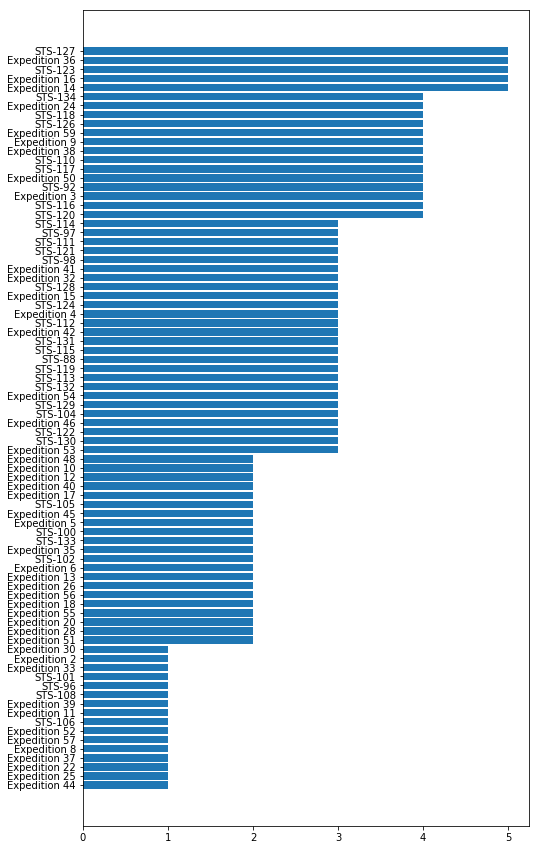

In [367]:
walks_per_mission = df_short['mission_name'].value_counts().sort_values()
plt.figure(figsize=(8, 15))
plt.barh(walks_per_mission.index, walks_per_mission);

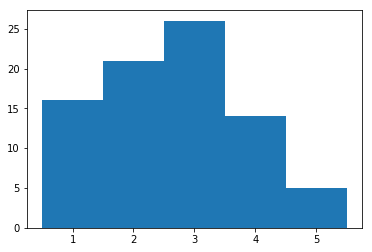

In [371]:
bins = np.arange(0.5, 6.5, 1)
plt.hist(walks_per_mission, bins=bins)
plt.xticks(np.arange(1, 6));

The maximum number of walks for any mission is 5, with the typical number being 3. 

The missions with the most walks are:
- STS-127
- Expedition 36
- STS-123
- Expedition 16
- Expedition 14

#### Dates

In [ ]:
per = df.Date.dt.to_period("M")  # new way to get the same

In [24]: g = df.groupby(per)

In [375]:
per_month = df_short['date'].dt.to_period('M')
month_counts = df_short.groupby(per_month)['date'].count().sort_index()
month_counts

date
1998-12    3
1999-05    1
2000-05    1
2000-09    1
2000-10    4
2000-12    3
2001-02    3
2001-03    2
2001-04    2
2001-06    1
2001-07    3
2001-08    2
2001-10    2
2001-11    1
2001-12    2
2002-01    2
2002-02    1
2002-04    4
2002-06    3
2002-08    2
2002-10    3
2002-11    3
2003-01    1
2003-04    1
2004-02    1
2004-06    2
2004-08    1
2004-09    1
2005-01    1
2005-03    1
          ..
2013-12    3
2014-01    1
2014-04    1
2014-06    1
2014-08    1
2014-10    3
2015-02    2
2015-03    1
2015-08    1
2015-10    1
2015-11    1
2015-12    1
2016-01    1
2016-02    1
2016-08    1
2016-09    1
2017-01    2
2017-03    2
2017-05    2
2017-08    1
2017-10    3
2018-01    1
2018-02    2
2018-03    1
2018-05    1
2018-06    1
2018-08    1
2018-12    1
2019-03    2
2019-04    2
Freq: M, Name: date, Length: 114, dtype: int64

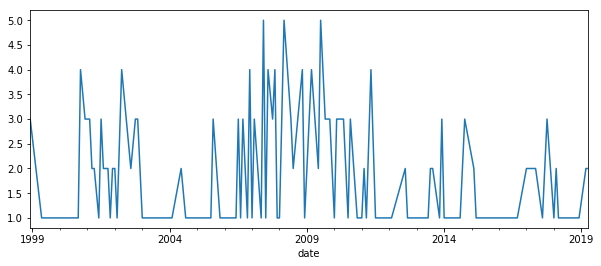

In [381]:
month_counts.plot(figsize=(10, 4));

We had a large peak of spacewalks from 2006 to 2010 (which makes some sense given the finacial crisis). The maximum number of walks per month is 5.

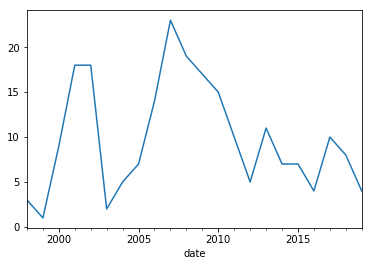

In [382]:
per_year = df_short['date'].dt.to_period('Y')
year_counts = df_short.groupby(per_year)['date'].count().sort_index()
year_counts.plot();

The most walks per year occurred in 2007 (more than 20), with 2001 and 2002 the next highest. These days it's more common to have five to ten walks per year.

Note: when summarizing by year, it may be helpful to truncate to 2018 as less than half of 2019 is complete.

#### Walk duration

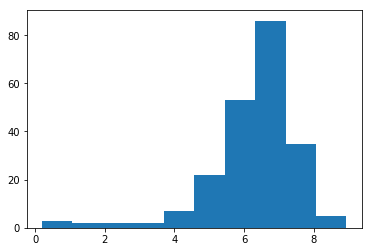

In [383]:
df_short['walk_duration'].hist(grid=False);

In [384]:
df_short['walk_duration'].describe()

count    217.000000
mean       6.246544
std        1.302569
min        0.200000
25%        5.733333
50%        6.483333
75%        7.016667
max        8.933333
Name: walk_duration, dtype: float64

The majority of walks are around 7 hours but there is a tail of very short walks with the minimum being 12 minutes and the maximum being almost 9 hours.

#### US v RUS

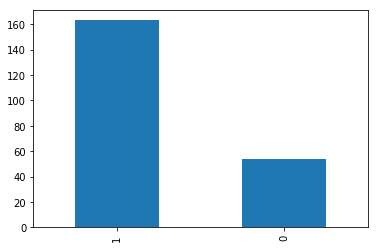

In [392]:
df_short['us_rus'].value_counts().plot(kind='bar');

There have been about 3 times as many spacewalks in US suits compared to RUS suits.

#### Spacewalkers

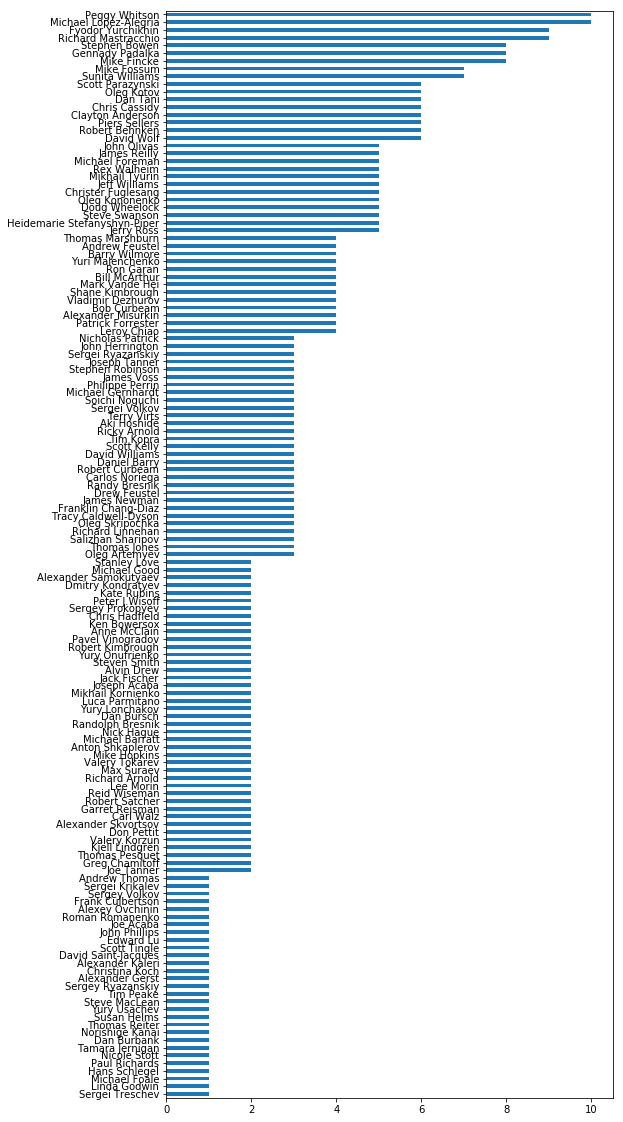

In [388]:
walker_counts = df_final['spacewalker'].value_counts().sort_values()
walker_counts.plot(kind='barh', figsize=(8, 20));

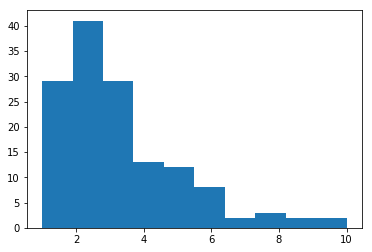

In [389]:
walker_counts.hist(grid=False);

It is most common for astronauts to have completed 3 space walks. The maximum number of spacewalks by any one person is 10, shared by [Peggy Whitson](https://www.nasa.gov/astronauts/biographies/peggy-a-whitson/biography) and [Michael Lopez-Alegra](https://en.wikipedia.org/wiki/Michael_L%C3%B3pez-Alegr%C3%ADa).

In [390]:
df_short['spacewalker'].value_counts().head()

Richard MastracchioClayton Anderson    4
Peggy WhitsonDan Tani                  4
Gennady PadalkaMike Fincke             4
David WolfPiers Sellers                3
Fyodor YurchikhinAlexander Misurkin    3
Name: spacewalker, dtype: int64

The most common combinations of astronauts are:
- Richard Mastracchio and Clayton Anderson
- Peggy Whitson and Dan Tani
- Gennady Padalka and Mike Fincke